# Transmission Line Fault Analysis

Predicts symmetrical and unsymmetrical short circuit faults on a transmission line<br><br>
SymmetRical faults: Symmetrical faults maintain the systems symmetry even after a fault occurs. Three phase to ground fault (LLLG), it is one of the most severe faults and also rare<br><br>
Unsymmetrical faults: Unsymmetrical faults are the most common Single line to ground fault (LG), double line to ground fault (LLG)

In [1]:
# Importing libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import permutation_importance



## Data Loading and Overview

In [2]:
url = r"C:\Users\owner\OneDrive\Desktop\backend\Fault_Analysis\merged_dataset.csv"

def load_data(url):
    df = pd.read_csv(url, sep=",")
    return df

In [3]:
df = load_data(url)

In [4]:
df.head()

,t,Va,Vb,Vc,Ia,Ib,Ic,Fault
0,0.0000,123.673155,-318.714610,195.041455,3827.709068,-9954.681312,6126.972245,0
1,0.0001,132.928422,-319.851525,186.923103,4117.440004,-9991.463731,5874.023726,0
2,0.0002,142.052661,-320.672826,178.620166,4403.112401,-10018.387070,5615.274666,0
3,0.0003,151.036833,-321.177694,170.140861,4684.443276,-10035.424470,5350.981195,0
4,0.0004,159.872046,-321.365624,161.493578,4961.154162,-10042.558910,5081.404750,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16004 entries, 0 to 16003
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       16004 non-null  float64
 1   Va      16004 non-null  float64
 2   Vb      16004 non-null  float64
 3   Vc      16004 non-null  float64
 4   Ia      16004 non-null  float64
 5   Ib      16004 non-null  float64
 6   Ic      16004 non-null  float64
 7   Fault   16004 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 1000.4 KB


In [6]:
df.shape

(16004, 8)

In [7]:
df.describe()

,t,Va,Vb,Vc,Ia,Ib,Ic,Fault
count,16004.000000,16004.000000,16004.000000,16004.000000,16004.000000,16004.000000,16004.000000,16004.000000
mean,0.200000,0.843025,0.074239,-0.774321,811.617302,80.453805,-892.071107,0.750187
std,0.115503,185.158509,228.305732,214.337091,25806.937879,20084.270608,27068.159572,1.089830
min,0.000000,-321.337862,-399.758521,-439.906216,-75450.670310,-75452.398310,-101459.969000,0.000000
25%,0.100000,-132.925858,-211.819511,-165.674065,-8867.564064,-8165.421349,-8931.921277,0.000000
50%,0.200000,2.755851,0.236431,-2.427893,174.618721,69.461964,-279.759159,0.000000
75%,0.300000,132.925860,211.819511,170.141151,9026.111438,8165.421349,8662.374220,2.000000
max,0.400000,321.337865,399.792289,440.461693,104412.724800,78820.581670,75455.416660,3.000000


## Data Cleaning

In [8]:
def check_missing_values(df):
    missing_values = df.isnull().sum()
    if missing_values.sum()>0:
        print(missing_values[missing_values]>0)
    else:
        print("No missing values")


def check_duplicates(df):
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"Duplicated rows: {duplicates}")
        # df = df.drop_duplicates(inplace=True)
        # dropped = df.duplicated().sum()
        # print(f"\nDuplicates: {dropped}")
    else:
        print("There are no duplicates")

In [9]:
check_missing_values(df)
check_duplicates(df)

No missing values
Duplicated rows: 4000


In [10]:
check_duplicates(df)

Duplicated rows: 4000


In [11]:
#Saving cleaned dataset to csv
# df.to_csv("Clean_fault_analysis.csv", index=False)

## Exploratory Data Analysis

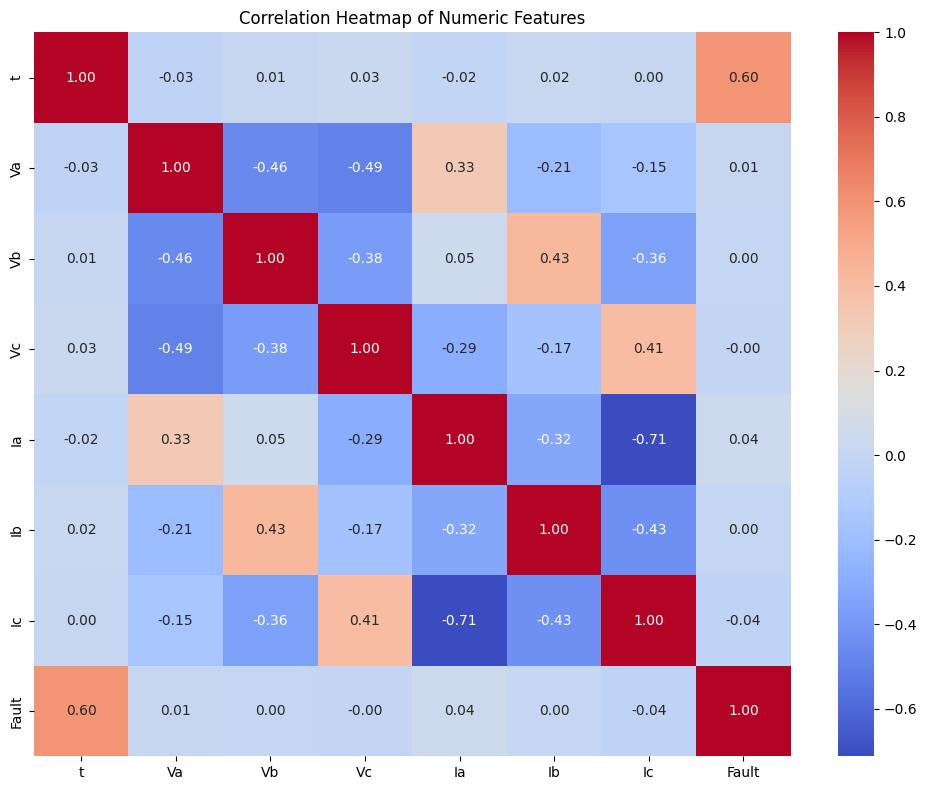

In [12]:
num_features = df.select_dtypes(include=[np.number])
if len(num_features.columns) >=4:
    plt.figure(figsize=(10,8))
    sns.heatmap(num_features.corr(), annot=True, cmap="coolwarm", fmt='.2f')
    plt.title("Correlation Heatmap of Numeric Features")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for a correlation heatmap")



Correlation of numeric variables with the target:
t     0.596000
Ia    0.037512
Va    0.005330
Ib    0.000897
Vb    0.000317
Vc   -0.004088
Ic   -0.036430
Name: Fault, dtype: float64


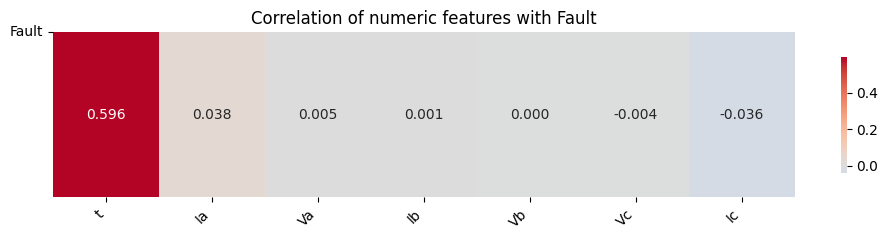

In [13]:

def corr_with_target(df, target):
    """
    Computes and prints correlation of all numeric columns with the target column.
    """

    # Select numeric columns
    num_df = df.select_dtypes(include='number')

    # Compute correlations with target
    corr_with_target = num_df.corr()[target].drop(labels=[target]).sort_values(ascending=False)

    # Print results
    print("\nCorrelation of numeric variables with the target:")
    print(corr_with_target)

    corrs_df = corr_with_target.to_frame(name = 'corr').T #Shape (1, n)

    #Heatmap
    plt.figure(figsize=(10,2.5))
    sns.heatmap(corrs_df, annot=True, fmt = ".3f",cmap="coolwarm",center = 0,
        # vmin = -1,
        # vmax = 1,
        cbar_kws = {'orientation': 'vertical', 'shrink': 0.7}
    )

    plt.xticks(rotation= 45, ha = 'right')
    plt.yticks([0], [target], rotation= 0)
    plt.title(f"Correlation of numeric features with {target}", fontsize=12)
    plt.tight_layout()
    plt.show()

corr_with_target(df, 'Fault')

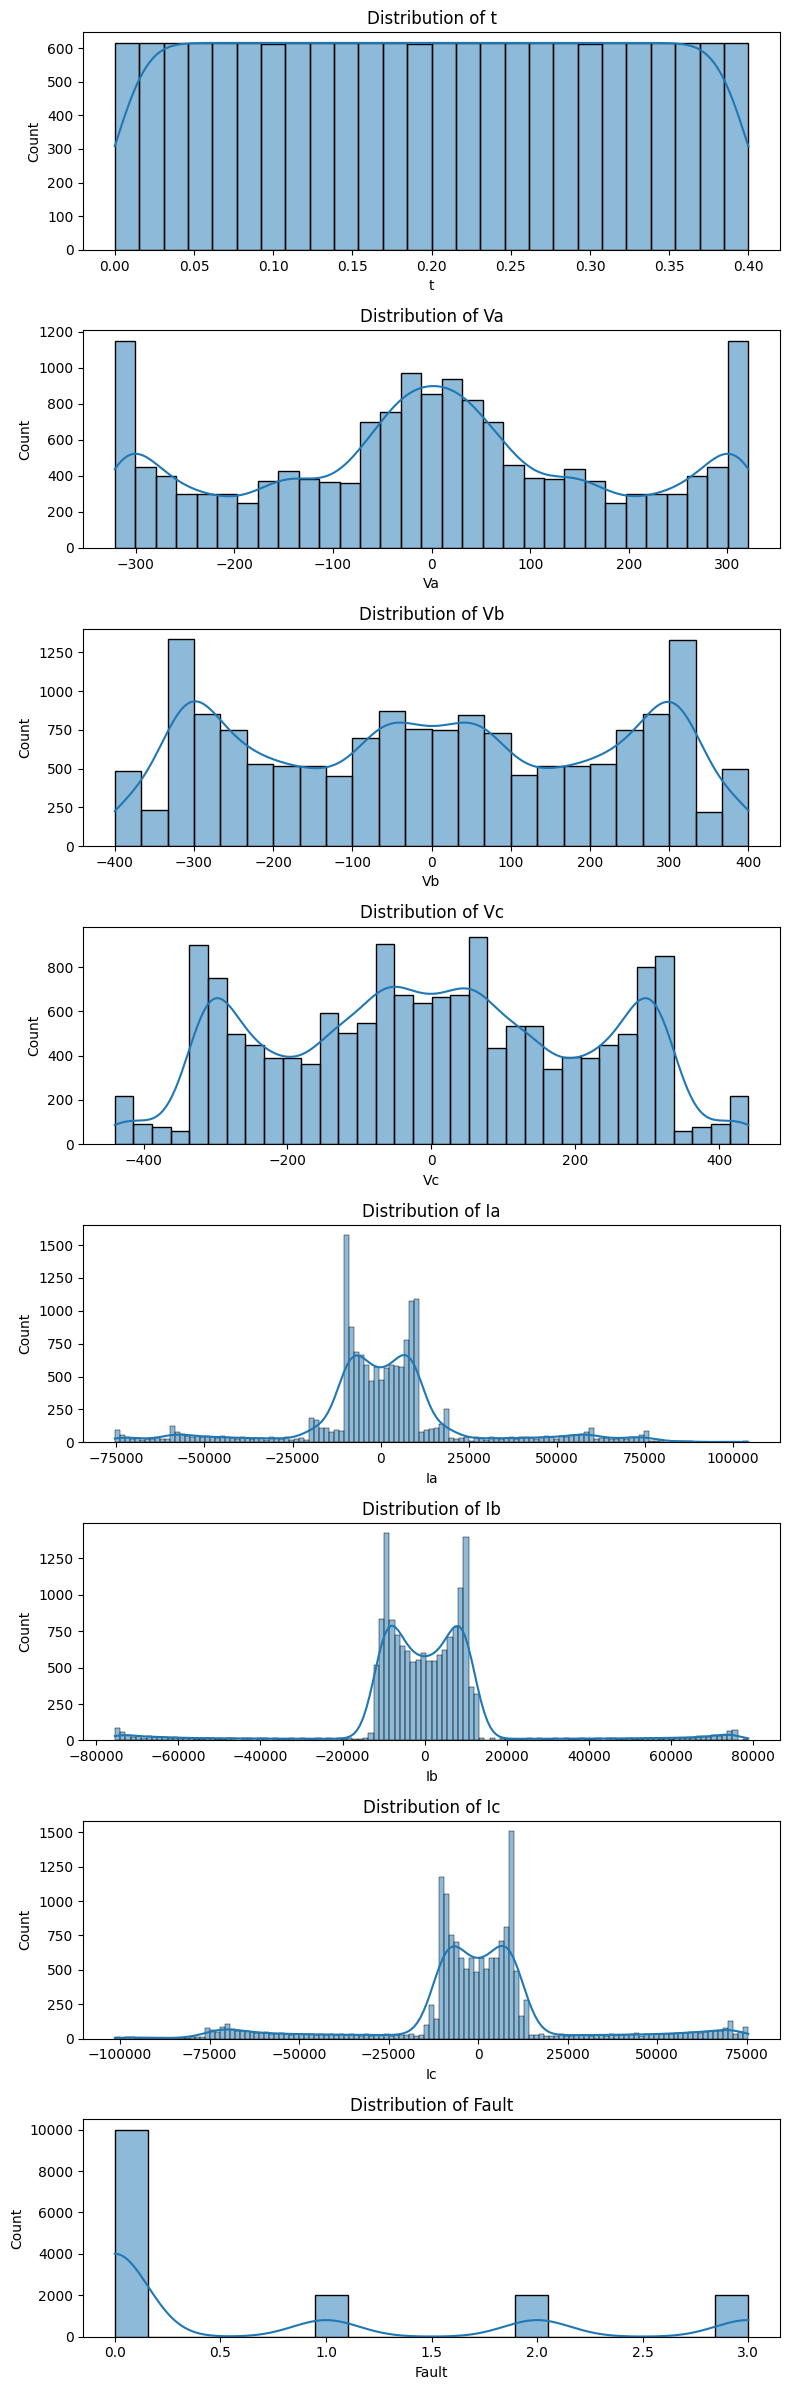

In [14]:
# Plot histograms for each column using seaborn's histplot
def histogram(features = num_features):
    numeric_columns = features.columns.tolist()

    fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(8, 3 * len(numeric_columns)))

    for ax, col in zip(axes, numeric_columns):
        sns.histplot(df[col], kde=True, ax=ax)
        ax.set_title(f'Distribution of {col}')

    plt.tight_layout()
    plt.show()

histogram()

In [15]:
df.columns

Index(['t', 'Va', 'Vb', 'Vc', 'Ia', 'Ib', 'Ic', 'Fault'], dtype='object')

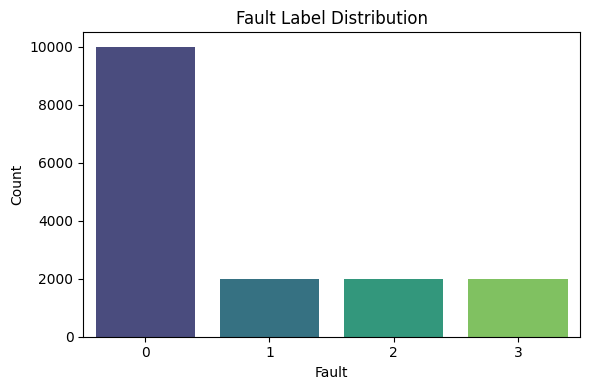

In [16]:
# Visualize the distribution of the 'Fault' column
def distribution(col = df["Fault"]):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df, palette='viridis')
    plt.title('Fault Label Distribution')
    plt.xlabel('Fault')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

distribution()

The "Fault" column contains categorical labels representing different system conditions: <br>
0 = No fault (Normal operation)

1 = LLLG fault (Three-phase-to-ground fault)

2 = LG fault (Line-to-ground fault)

3 = LLG fault (Line-line-to-ground fault)

In [17]:
df = df.replace({"Fault":{0: "No fault", 1: "LLLG fault", 2 :"LG fault", 3: "LLG fault"}})

The "Fault" column contains categorical labels representing different system conditions: <br>
0 = No fault (Normal operation)

1 = LLLG fault (Three-phase-to-ground fault)

2 = LG fault (Line-to-ground fault)

3 = LLG fault (Line-line-to-ground fault)

In [18]:
df["Fault"].unique()

array(['No fault', 'LG fault', 'LLG fault', 'LLLG fault'], dtype=object)

## Preprocessing

Should include some feature engineering to increase the correlation of the low signal features<br>
drop the column for time as it doesn't provide any predictive information

**Feature Engineering**

Time domain features
RMS: short circuit fault causes a drop in voltage rms (teh faults being)
Peak-to-peak: 

In [19]:
X = df.drop(columns="Fault")
y = df['Fault']

In [20]:
#Scaling 
scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler.fit_transform(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=234, stratify=y)

## Modelling

In [22]:
models = {
    "LogisticRegression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbours": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Ada Boost": AdaBoostClassifier(),
    "Extra Trees": ExtraTreesClassifier()
}

Training LogisticRegression...
LogisticRegression Accuracy: 0.624
              precision    recall  f1-score   support

    LG fault       0.24      0.20      0.22       400
   LLG fault       0.44      0.07      0.12       400
  LLLG fault       0.23      0.19      0.21       400
    No fault       0.73      0.91      0.81      2001

    accuracy                           0.62      3201
   macro avg       0.41      0.34      0.34      3201
weighted avg       0.57      0.62      0.58      3201



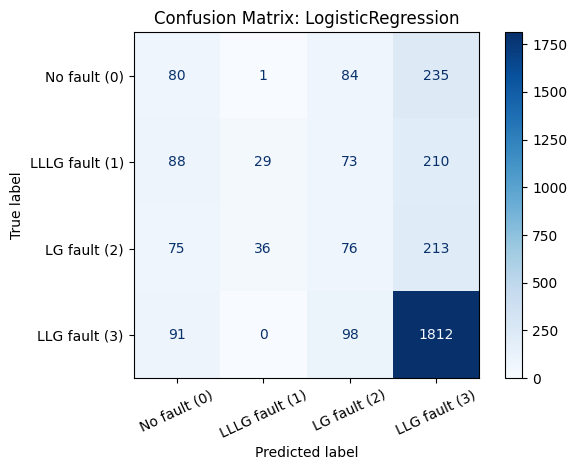

Training Random Forest...
Random Forest Accuracy: 0.999
              precision    recall  f1-score   support

    LG fault       1.00      1.00      1.00       400
   LLG fault       1.00      1.00      1.00       400
  LLLG fault       1.00      1.00      1.00       400
    No fault       1.00      1.00      1.00      2001

    accuracy                           1.00      3201
   macro avg       1.00      1.00      1.00      3201
weighted avg       1.00      1.00      1.00      3201



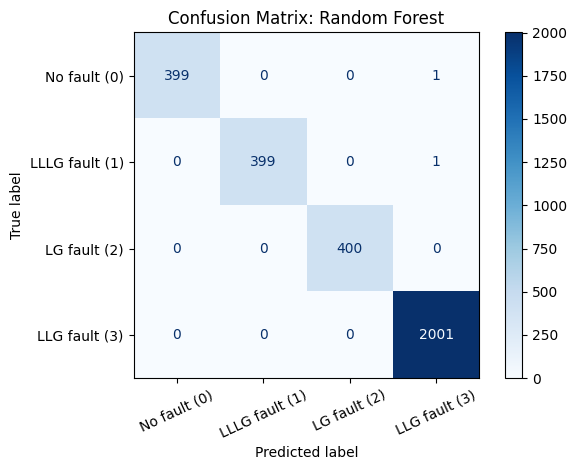

Training Decision Tree...
Decision Tree Accuracy: 0.999
              precision    recall  f1-score   support

    LG fault       1.00      1.00      1.00       400
   LLG fault       1.00      0.99      1.00       400
  LLLG fault       1.00      1.00      1.00       400
    No fault       1.00      1.00      1.00      2001

    accuracy                           1.00      3201
   macro avg       1.00      1.00      1.00      3201
weighted avg       1.00      1.00      1.00      3201



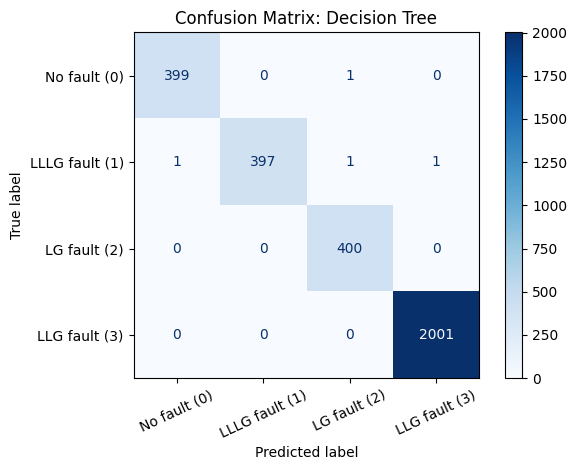

Training K-Nearest Neighbours...
K-Nearest Neighbours Accuracy: 0.990
              precision    recall  f1-score   support

    LG fault       0.97      0.95      0.96       400
   LLG fault       1.00      1.00      1.00       400
  LLLG fault       1.00      1.00      1.00       400
    No fault       0.99      0.99      0.99      2001

    accuracy                           0.99      3201
   macro avg       0.99      0.99      0.99      3201
weighted avg       0.99      0.99      0.99      3201



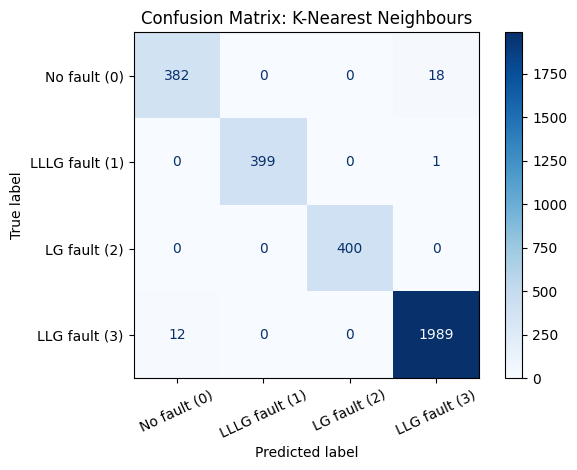

Training Naive Bayes...
Naive Bayes Accuracy: 0.933
              precision    recall  f1-score   support

    LG fault       0.76      0.80      0.78       400
   LLG fault       1.00      0.87      0.93       400
  LLLG fault       0.99      1.00      0.99       400
    No fault       0.95      0.96      0.95      2001

    accuracy                           0.93      3201
   macro avg       0.92      0.91      0.91      3201
weighted avg       0.94      0.93      0.93      3201



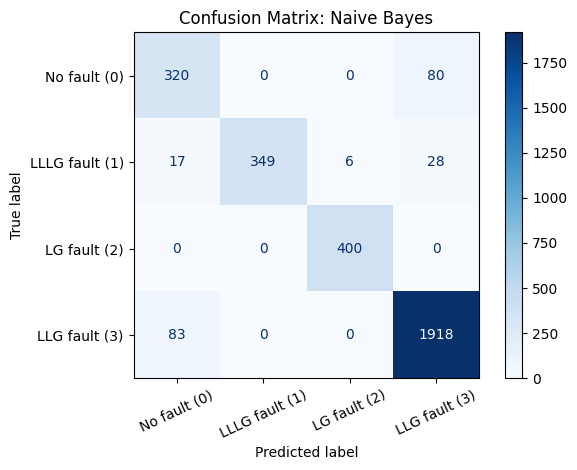

Training Ada Boost...
Ada Boost Accuracy: 0.919
              precision    recall  f1-score   support

    LG fault       0.69      0.80      0.74       400
   LLG fault       0.91      0.94      0.92       400
  LLLG fault       1.00      0.91      0.95       400
    No fault       0.96      0.94      0.95      2001

    accuracy                           0.92      3201
   macro avg       0.89      0.90      0.89      3201
weighted avg       0.93      0.92      0.92      3201



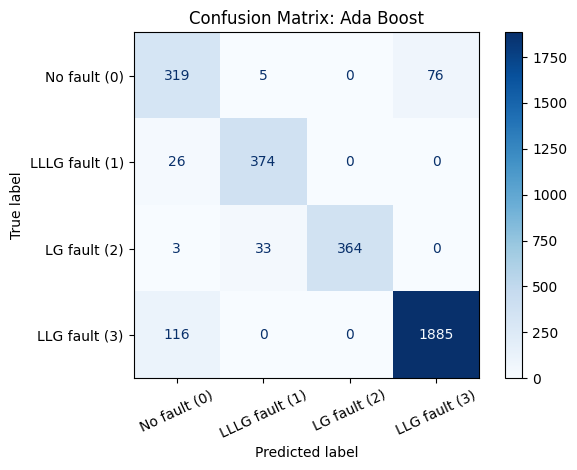

Training Extra Trees...
Extra Trees Accuracy: 0.999
              precision    recall  f1-score   support

    LG fault       1.00      1.00      1.00       400
   LLG fault       1.00      1.00      1.00       400
  LLLG fault       1.00      1.00      1.00       400
    No fault       1.00      1.00      1.00      2001

    accuracy                           1.00      3201
   macro avg       1.00      1.00      1.00      3201
weighted avg       1.00      1.00      1.00      3201



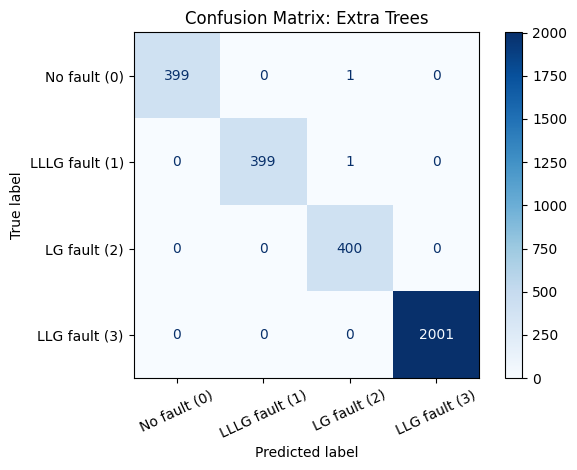

,Model,Accuracy
1,Random Forest,0.999375
6,Extra Trees,0.999375
2,Decision Tree,0.998750
3,K-Nearest Neighbours,0.990316
4,Naive Bayes,0.933146
5,Ada Boost,0.919088
0,LogisticRegression,0.623868


In [23]:
# Initializing a dictionary to store the models
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy:.3f}")

    #Adding confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=['No fault (0)',"LLLG fault (1)", "LG fault (2)", "LLG fault (3)" ])
    print(classification_report(y_test, y_pred, zero_division=1))

    #Plotting with model name as title
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xticks(rotation = 25)
    plt.tight_layout()
    plt.show()

result_df = pd.DataFrame(results.items(), columns=["Model", "Accuracy"])
result_df = result_df.sort_values(by="Accuracy", ascending=False)
result_df.reset_index(drop=True)
result_df